In [22]:
# generic libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# project specific custom libraries
from config import *
from simulation import simulate_decay_times
from analysis import *

from joblib import delayed, Parallel

In [23]:
#set a seed for numpys random number generator
# np.random.seed(42)

In [24]:
t_bounds = [0, 20000e-9]
n = 10000
n_sims = 1000

MUON_estimate = 2e-6
PION_estimate = 1.2e-8
initial_guess = [MUON_estimate, PION_estimate]

In [25]:
def simulation(n, t_bounds, initial_guess, bins=150):

    simulated_decay_points = simulate_decay_times(n, t_bounds[1])
    counts, bins = np.histogram(simulated_decay_points[:, 0] , bins=150, density=False)

    return binned_maximum_likelihood_fit_2(counts, bins, initial_guess)

In [26]:
# simulation_results = [simulation(n, t_bounds, initial_guess) for _ in range(n_sims)]
simulation_results = Parallel(n_jobs=-1)(delayed(simulation)(n, t_bounds, initial_guess) for _ in range(n_sims))

/Users/tillboehringer/Dropbox/Studium/Physik/Semester4/PHY241_Project/PHY241/Code/config.py:14: RuntimeWarning: overflow encountered in exp
  second_part = exp(- t / muon_mean_lifetime) - exp(- t / pion_mean_lifetime)
/Users/tillboehringer/Dropbox/Studium/Physik/Semester4/PHY241_Project/PHY241/Code/analysis.py:163: RuntimeWarning: invalid value encountered in log
  nll = - np.sum(counts * np.log(estimated_counts))
/Users/tillboehringer/Dropbox/Studium/Physik/Semester4/PHY241_Project/PHY241/Code/analysis.py:163: RuntimeWarning: divide by zero encountered in log
  nll = - np.sum(counts * np.log(estimated_counts))
/Users/tillboehringer/Dropbox/Studium/Physik/Semester4/PHY241_Project/PHY241/Code/analysis.py:163: RuntimeWarning: invalid value encountered in multiply
  nll = - np.sum(counts * np.log(estimated_counts))
/Users/tillboehringer/Dropbox/Studium/Physik/Semester4/PHY241_Project/PHY241/Code/config.py:14: RuntimeWarning: overflow encountered in exp
  second_part = exp(- t / muon_mean_

In [27]:
simulation_results = pd.DataFrame(np.array(simulation_results), columns=['MUON_estimate', 'PION_estimate', 'MUON_uncer', 'PION_uncer'])
simulation_results.replace([np.inf, -np.inf], np.nan, inplace=True)
simulation_results.dropna(inplace=True)

In [28]:
simulation_results

,MUON_estimate,PION_estimate,MUON_uncer,PION_uncer
0,2.254653e-08,0.000002,0.0,0.0
1,2.665566e-08,0.000002,0.0,0.0
2,2.266013e-08,0.000002,0.0,0.0
3,2.358862e-08,0.000002,0.0,0.0
4,2.753204e-08,0.000002,0.0,0.0
...,...,...,...,...
995,2.957641e-08,0.000002,0.0,0.0
996,2.340876e-08,0.000002,0.0,0.0
997,2.362278e-08,0.000002,0.0,0.0
998,2.281060e-08,0.000002,0.0,0.0


In [29]:
simulation_results = simulation_results[simulation_results['MUON_estimate']>0]

In [30]:
MUON_mean = simulation_results['MUON_estimate'].mean()
PION_mean = simulation_results['PION_estimate'].mean()
MUON_uncer = np.sqrt(np.mean(np.power(simulation_results['MUON_uncer'],2)))
PION_uncer = np.sqrt(np.mean(np.power(simulation_results['PION_uncer'],2)))
print(MUON_uncer)

0.0


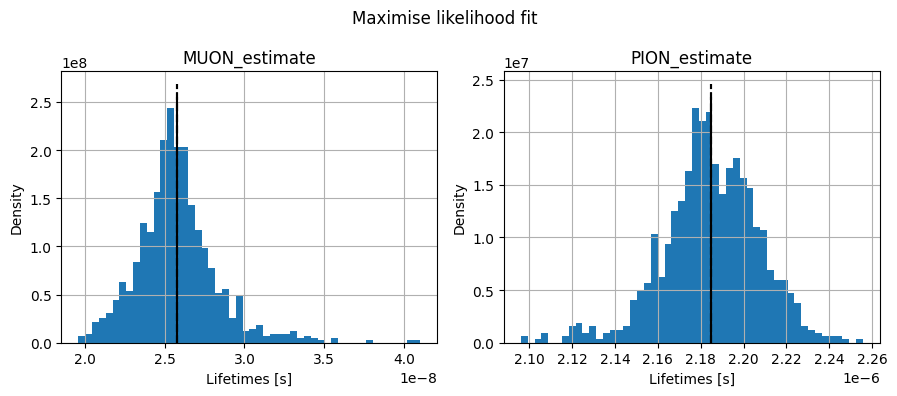

In [34]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(9,4))
simulation_results.hist(column=['MUON_estimate'], ax=ax[0], bins=50, density=True)
simulation_results.hist(column=['PION_estimate'], ax=ax[1], bins=50, density=True)
for i in ax:
    i.set_ylabel('Density')
    i.set_xlabel('Lifetimes [s]')

ax[0].vlines(MUON_mean, *ax[0].get_ylim(), color='k')
ax[1].vlines(PION_mean, *ax[1].get_ylim(), color='k')

ax[0].vlines([MUON_mean + MUON_uncer, MUON_mean - MUON_uncer], *ax[0].get_ylim(), color='k', linestyle='--')
ax[1].vlines([PION_mean + PION_uncer, PION_mean - PION_uncer], *ax[1].get_ylim(), color='k', linestyle='--')

fig.suptitle('Maximise likelihood fit')
plt.tight_layout()